# $k$-means clustering

$k$-means clustering aims to partition the instances space into $k$ clusters, in which each observation
belongs to the cluster with the nearest mean.

## Implementation

### Function to load datasets

Here, train and test datasets will be used together. Also, since this is an unsupervised technique, 
the target column will be removed:

In [1]:
import pandas as pd

def load_dataset(paths):
    '''
    Load the datasets in paths.
    '''
    # load train and test datasets together
    dataset = pd.concat([pd.read_csv(f) for f in paths])
    # keep targets for future comparative purposes
    targets = dataset['cover_type']
    # remove target column
    dataset.drop('cover_type', inplace=True, axis=1)
    # check shape
    print("[INFO] Dataset shape: ", dataset.shape)
    # return
    return dataset

### Methodology

#### Varying $k$

$k$ is the number of clusters to be constructed during the execution. It is important to vary it in order to 
seek for better partitions. In this work, $k \in \{2,3, \ldots, 13\}$. Notice that the number of classes
is in the middle of this interval.

#### Number of executions

For each value of $k$, $5$ executions will be performed.

#### Davies-Bouldin (DB) index

Every clustering will then be evaluated in the view of the Davies-Bouldin (DB) index:

$$
R_{ij} = \frac{s_i + s_j}{d_{ij}}
$$

$$
D_i = \max_{j\neq i}R_{ij}
$$

$$
DB = \frac 1 k \sum_i D_i
$$

### Function to perform $k$-means

Here, the `sklearn` library will be used for performing the executions described in the methodology:

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import itertools
import time
import numpy as np

def perform_kmeans(dataset, ks, iterations):
    '''
    Perform k-means.
    
    @param dataset The dataset.
    @param ks list of ks to be considered
    @param iterations number of iterations per k
    
    @return (execution results, models)
    '''
    # iterations
    ns = list(range(iterations))
    # store execution results
    results_execs = []
    # store models
    models = {}
    # iterate over ns
    for n in ns:
        # seed
        ms = round(((time.time()*1000.0) - 0)/(2**32-1 - 0))
        # for each k
        for k in ks:
            print("[INFO] k =", k, ", n =", n)
            # perform k-means
            kmeans = KMeans(n_clusters=k, 
                            random_state=ms).fit(dataset)
            # store model
            models[(k, n)] = kmeans
            # retrieve labels
            labels = kmeans.labels_
            # compute DB index
            db = davies_bouldin_score(dataset, labels)
            # store results
            results_execs.append([k, n, ms, db])
    # make dataframe from results
    results_execs = pd.DataFrame(results_execs, 
                                 columns=['k', 
                                          'iteration',
                                          'random_seed',
                                          'db_index'])
    return (results_execs, models)

### Function to compute the average DB per $k$ and best partition

In [3]:
def best_avgdb_partition(results_execs):
    '''
    Compute average dbs per k and the best partition
    based on the minimum of the least average db k.
    
    @param results_execs execution results
    
    @return (average dbs, best partition)
    '''
    # take average
    results_execs_avg = results_execs.groupby('k', axis=0).mean()['db_index']
    # get the k with min db average
    best_k = results_execs_avg.idxmin()
    # take the partition id with best_k clusters and min db
    best_partition_idx = results_execs[results_execs['k']==best_k]['db_index'].idxmin()
    # take the partition
    best_partition = results_execs.iloc[best_partition_idx]
    # return
    return (results_execs_avg, best_partition)

### Function to save the best  partition

In [4]:
from sklearn.externals import joblib

def save_best_partition_model(models, best_partition, model_name):
    '''
    Takes models and best_partition and save the model.
    
    @param models
    @param best_partition
    '''
    # recover the model
    model = models[(int(best_partition['k']), 
                    int(best_partition['iteration']))]
    # dump it
    joblib.dump(model, model_name)

### Function to save the results

In [5]:
def save_results(results_execs, results_execs_avg, results_file_name, results_avg_file_name):
    '''
    Save results.
    '''
    results_execs.to_csv(results_file_name,
                         index=False)
    results_execs_avg.to_csv(results_avg_file_name)

### Function to perform all steps

In [6]:
def perform(paths, ks, iterations, model_file_name, results_file_name, results_avg_file_name):
    '''
    Pipeline using the functions define above.
    '''
    # load dataset
    dataset = load_dataset(paths)
    # perform k-means
    results_execs, models = perform_kmeans(dataset, ks, iterations)
    # best partition and db avg
    results_execs_avg, best_partition = best_avgdb_partition(results_execs)
    # save results and model
    save_best_partition_model(models, best_partition, model_file_name)
    save_results(results_execs, results_execs_avg, results_file_name, results_avg_file_name)
    # return
    return (results_execs, results_execs_avg, best_partition)

### Performing

In [7]:
ks = list(range(2,14))
original_results = perform(['../datasets/covertype_norm_train.csv', 
                            '../datasets/covertype_norm_test.csv'],
                          ks, 
                           5,
                           '../models/kmeans_original_best.save',
                          '../results/kmeans_original_results.csv',
                          '../results/kmeans_original_avgdb.csv')
lda_results = perform(['../datasets/covertype_lda_train.csv', 
                       '../datasets/covertype_lda_test.csv'],
                          ks, 
                           5,
                           '../models/kmeans_lda_best.save',
                          '../results/kmeans_lda_results.csv',
                          '../results/kmeans_lda_avgdb.csv')

[INFO] Dataset shape:  (19229, 54)
[INFO] k = 2 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 3 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 2 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 3 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 2 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 3 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 2 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 3 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 2 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 3 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] Dataset shape:  (19229, 6)
[INFO] k = 2 , n = 0
[INFO] k = 3 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 0


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 2 , n = 1
[INFO] k = 3 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 1


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 2 , n = 2
[INFO] k = 3 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 2


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 2 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 3 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 3


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 2 , n = 4
[INFO] k = 3 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 4 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 5 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 6 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 7 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 8 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 9 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 10 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 11 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 12 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[INFO] k = 13 , n = 4


/home/vitorgreati/miniconda3/envs/ia/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


## Results

### Plot $k$ $\times$ average DB

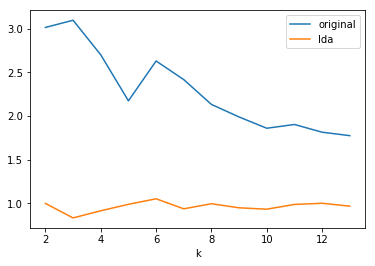

In [20]:
# retrieve averages
_,or_results_execs_avg,_= original_results
_,lda_results_execs_avg,_= lda_results
# use pandas to plot
ax = or_results_execs_avg.plot.line()
ax = lda_results_execs_avg.plot.line()
ax.legend(['original','lda'])